In [1]:
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt
from scipy.integrate import odeint
from scipy.interpolate import interp1d
from tqdm import tqdm
import scipy
import spiceypy as spice
import rebound
import reboundx
import matplotlib
import pandas as pd

import sys
sys.path.append('..')
from geminids.weights import *
from geminids.beta2mass import asteroidal as asteroidal
from geminids.constants import *
from geminids.cometary_start import init_loc

plt.rcParams.update({
  "text.usetex": True,
  "font.family": "Computer Modern Roman",
  "font.size":    14.0
})

In [2]:
points_novel = []
points_vel = []
points_distr = []
n = 1
pth = "../output/"

for i in tqdm(range(n)):
    data = np.load(f'{pth}novel/particles{i}.npy')
    beta = np.load(f'{pth}novel/beta{i}.npy')
    size = np.load(f'{pth}novel/mass{i}.npy')
    size = asteroidal(beta)
    data = data.reshape(10000*10*2, 5)
    data = data[:,:3]
    
    
    
    points_novel.append(np.hstack((data, np.tile(size,2000).reshape(200000,1), 
                                   np.tile(weight_novel(beta),2000).reshape(200000,1))))
    
points_novel = np.array(points_novel)
points_novel = points_novel.reshape(200000*n,5)


n=1
for i in tqdm(range( n)):
    data = np.load(f'{pth}vel/particles{i}.npy')
    beta = np.load(f'{pth}vel/beta{i}.npy')
    size = np.load(f'{pth}vel/mass{i}.npy')
    size = asteroidal(beta)
    data = data.reshape(1000*100*2, 5)
    data = data[:,:3]
    
    
    
    points_vel.append(np.hstack((data, np.tile(size,2000).reshape(200000,1),
                                 np.tile(weight_vel(beta),2000).reshape(200000,1))))
    
points_vel = np.array(points_vel)
points_vel = points_vel.reshape(200000*n,5)
offset = 0
n = 100
orbit = np.load("../data/orig_orbit.npy")
for i in tqdm(range(n*10)):
        # try:
            data = np.load(f'{pth}comet/particles{i}.npy')
            beta = np.load(f'{pth}comet/beta{i}.npy')
            size = np.load(f'{pth}comet/mass{i}.npy')
            mask = beta < .5
            size[mask] = asteroidal(beta[mask])
            size[~mask] = 0
            data = data.reshape(10000*10*2, 5)
            # try:
                
            __, r, t = init_loc(int(i/10), orbit)
            t = np.tile(t, 100)
            r = np.tile(r, 100)
            # except Exception as e:
                # print(e)
            # data[data[:,4] < .2] *= 0
            data = data[:,:3]
            # beta = np.tile(beta, 20000).reshape(200000,)
            # print(beta.shape)
            
            # w = weight_cometary(beta, r, t)
            # print(w.shape)
            # print(r)

            points_distr.append(np.hstack((data, np.tile(size,2000).reshape(200000,1), 
                                   np.tile(weight_cometary(beta, r, t),2000).reshape(200000,1),
                                   np.tile(r,2000).reshape(200000,1))))
        # except Exception as e: 
        #     print(e)
        #     offset +=1

points_distr = np.array(points_distr)
points_distr = points_distr.reshape(200000*(n*10 - offset),6)
points_novel = points_novel[~np.isnan(points_novel).any(axis=1)]
points_vel = points_vel[~np.isnan(points_vel).any(axis=1)]
points_distr = points_distr[~np.isnan(points_distr).any(axis=1)]
points_distr = points_distr[points_distr[:,0] != 0]

 11%|█         | 108/1000 [00:58<07:36,  1.95it/s]../geminids/weights.py:40: RuntimeWarning: invalid value encountered in greater
  arr[mask][asteroidal(b[mask]) > 10] = 0
../geminids/weights.py:41: RuntimeWarning: invalid value encountered in less
  arr[mask][asteroidal(b[mask]) < 1e-16] = 0
100%|██████████| 1000/1000 [20:52<00:00,  1.25s/it]


In [3]:
orbit = np.load('../geminids/data/phaethon.npy')
psp2 = np.load('../geminids/data/psp.npy')
orbit = orbit.reshape((20000,5))[:,:3].copy()
psp2 = psp2[:,:3].copy()


transform = spice.pxform("J2000", "ECLIPJ2000", 0)

print("Transforming")

# points_novel[:,:3] = np.dot(transform, points_novel[:,:3].T).T
# points_vel[:,:3] = np.dot(transform, points_vel[:,:3].T).T
# points_distr[:,:3] = np.dot(transform, points_distr[:,:3].T).T
orbit = np.dot(transform, orbit.T).T
psp2 = np.dot(transform, psp2.T).T

diffs = np.array( np.sqrt(np.sum([(orbit[1:,i] - orbit[:-1,i]) ** 2 for i in range(3)], axis=0)) )
arc = np.cumsum(diffs)

Transforming


0

In [4]:
def spectogram_plot(orig_points, min_y=0, max_y=1, bins=40):
    r = np.sqrt(orbit[:,0]**2 + orbit[:,1]**2 + orbit[:,2]**2)
    peri = np.argmin(r)
    points = orig_points


    perihelion = np.array((orbit[peri,0], orbit[peri,1], orbit[peri, 2]))
    point_2 = np.array((orbit[peri-10000,0], orbit[peri-10000,1], orbit[peri-10000, 2]))

    # perihelion, point_2 = point_2, perihelion

    p = np.sqrt(np.sum(perihelion**2))
    r = np.sqrt(points[:,0]**2 + points[:,1]**2 + points[:,2]**2)
    orbit_r = np.sqrt(orbit[:,0]**2 + orbit[:,1]**2 + orbit[:,2]**2)

    plane = np.cross(perihelion, point_2)
    plane = plane/np.sqrt(np.sum(plane**2))
    n = np.cross(perihelion, plane)
    n = n/np.sqrt(np.sum(n**2))
    



    # dot = (points[:,0] * perihelion[0] + points[:,1] * perihelion[1] + points[:,2] * perihelion[2])
    # ndot= np.sum([points[:,j] * n[j] for j in range(3)], axis=0)
    # ndot[ndot >= 0] = 1
    # ndot[ndot <= 0] = -1
    # theta = np.arccos(dot/(p * r)) * ndot




    # orbit_dot = (orbit[:,0] * perihelion[0] + orbit[:,1] * perihelion[1])
    # ndot_o = np.sum([orbit[:,j] * n[j] for j in range(3)], axis=0)
    # ndot_o[ndot_o >= 0] = 1
    # ndot_o[ndot_o <= 0] = -1


    ndot= np.sum([points[:,j] * n[j] for j in range(3)], axis=0)
    pdot= np.sum([points[:,j] * plane[j] for j in range(3)], axis=0)
    proj = np.array([points[:,j] - pdot * plane[j] for j in range(3)])
    r = np.sqrt(proj[0]**2 + proj[1]**2 + proj[2]**2)
    dot = (proj[0] * perihelion[0] + proj[1] * perihelion[1] + proj[2] * perihelion[2] )
    ndot[ndot >= 0] = 1
    ndot[ndot <= 0] = -1
    theta = np.arccos(dot/(p * r)) * ndot

    """
    Remove the following
    """
    grid = 35
    x = np.linspace(-2.5, 0.5, grid*2)
    y = np.linspace(-0.75, 0.75, grid*2)
    c = np.zeros((grid*2)**2)
    nx, ny = np.meshgrid(x, y)
    
    poly = plt.hexbin(np.hstack((r*np.cos(theta), nx.flatten())), np.hstack((r*np.sin(theta), ny.flatten())), cmap = "plasma", 
                  extent = (-2.5,0.5,-0.75,0.75), gridsize=grid, C = np.hstack((orig_points[:,4], c)),
                  reduce_C_function = np.sum)

    plt.close()
    offsets = poly.get_offsets()
    C = poly.get_array()

    dx = np.unique(np.sort(offsets, axis=0)[:,0])[1] - np.unique(np.sort(offsets, axis=0)[:,0])[0]
    dy = np.unique(np.sort(offsets, axis=0)[:,1])[1] - np.unique(np.sort(offsets, axis=0)[:,1])[0]

    V = 2*dx*dy*(au**2)/(1e3**2)

    plt.hexbin(offsets[:,0], offsets[:,1], C=C/np.max(C), cmap="plasma", gridsize=grid)
    plt.show()

    """
    End Remove
    """


    # orbit_dot = (peri_orbit[:,0] * perihelion[0] + peri_orbit[:,1] * perihelion[1])
    # orbit_orth = peri_orbit[:,:2] - np.array([orbit_dot / p**2 * perihelion[0], orbit_dot / p**2 * perihelion[1]]).T
    # orbit_theta = np.arccos(orbit_dot/(p * orbit_r)) * orbit_orth[:, 0]/(np.abs(orbit_orth[:, 0])+1e-10)

    ndot= np.sum([orbit[:,j] * n[j] for j in range(3)], axis=0)
    pdot= np.sum([orbit[:,j] * plane[j] for j in range(3)], axis=0)
    o_proj = np.array([orbit[:,j] - pdot * plane[j] for j in range(3)])
    orbit_r = np.sqrt(o_proj[0]**2 + o_proj[1]**2 + o_proj[2]**2)
    o_dot = (o_proj[0] * perihelion[0] + o_proj[1] * perihelion[1] + o_proj[2] * perihelion[2] )
    ndot[ndot > 0] = 1
    ndot[ndot < 0] = -1
    ndot[(ndot==0) * (orbit_r > 0.5)] = -1
    ndot[(ndot==0) * (orbit_r <= 0.5)] = 1
    arg = o_dot/(p * orbit_r)
    arg[(arg > 1) * (arg < 1.05)] = 1
    orbit_theta = np.arccos(arg) * ndot


    # orbit_theta = np.arccos(orbit_dot/(p * orbit_r)) * ndot_o

    start = 4796
    end = -907
    mask = (np.abs(theta) > np.min(np.hstack((-orbit_theta[:-1][start:end][orbit_theta[:-1][start:end]<0], orbit_theta[:-1][start:end][orbit_theta[:-1][start:end]>0])))) * (theta < np.max(orbit_theta[:-1][start:end])-.01) * (theta > np.min(orbit_theta[:-1][start:end])+.01)

    points = orig_points.copy()
    x_offset = scipy.interpolate.interp1d(orbit_theta, orbit[:,0])
    y_offset = scipy.interpolate.interp1d(orbit_theta, orbit[:,1])
    z_offset = scipy.interpolate.interp1d(orbit_theta, orbit[:,2])
    r_offset = scipy.interpolate.interp1d(orbit_theta, orbit_r)
    radius = scipy.interpolate.interp1d(orbit_theta, orbit_r*orbit_theta/(np.abs(orbit_theta) + 1e-10))


    arc_len = scipy.interpolate.interp1d(orbit_theta[:-1][start:end],  arc[start:end] - arc[peri])


    points[mask,0] -= x_offset(theta[mask])
    points[mask,1] -= y_offset(theta[mask])
    points[mask,2] -= z_offset(theta[mask])
    r2 = np.sqrt(points[mask,0]**2 + points[mask,1] ** 2 + points[mask,2]**2)


    grid = bins
    extent = (arc_len(orbit_theta[:-1][start:end]).min(), arc_len(orbit_theta[:-1][start:end][~np.isnan(orbit_theta[:-1][start:end])]).max(), min_y, max_y)
    poly = plt.hexbin(arc_len(theta[mask]), r2, 
                    cmap = 'plasma', gridsize = grid, C = points[mask,4], 
                    reduce_C_function = np.sum, extent = extent)

    plt.xlabel("Arc Length [AU]")
    plt.ylabel("Offset from 3200 Phaethon [AU]")

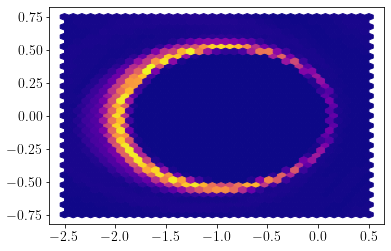

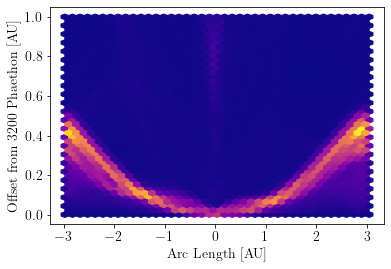

In [32]:
spectogram_plot(points_novel)
plt.savefig("../figures/novel_spectogram.eps")

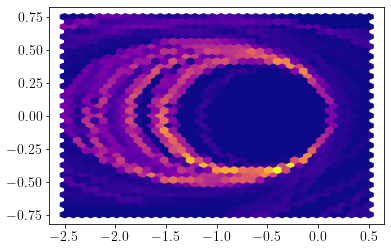

NameError: name 'arc' is not defined

In [5]:
spectogram_plot(points_vel, 0, 1)
plt.savefig("../figures/vel_spectogram.eps")

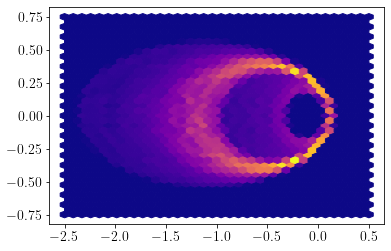

NameError: name 'arc' is not defined

In [6]:
spectogram_plot(points_distr[points_distr[:,3] > 1e-10], 0, 1, 35)
plt.savefing("../figures/distr_spectogram.eps")

In [18]:
points_novel.shape

(18850000, 5)

In [16]:
points_distr.shape

(13396000, 6)

In [ ]:
start = 4796
end = -907
mask = (np.abs(theta) > np.min(np.hstack((-orbit_theta[:-1][start:end][orbit_theta[:-1][start:end]<0], orbit_theta[:-1][start:end][orbit_theta[:-1][start:end]>0])))) * (theta < np.max(orbit_theta[:-1][start:end])-.01) * (theta > np.min(orbit_theta[:-1][start:end])+.01)

points = points_novel.copy()
x_offset = scipy.interpolate.interp1d(orbit_theta, orbit[:,0])
y_offset = scipy.interpolate.interp1d(orbit_theta, orbit[:,1])
z_offset = scipy.interpolate.interp1d(orbit_theta, orbit[:,2])
r_offset = scipy.interpolate.interp1d(orbit_theta, orbit_r)
radius = scipy.interpolate.interp1d(orbit_theta, orbit_r*orbit_theta/(np.abs(orbit_theta) + 1e-10))


arc_len = scipy.interpolate.interp1d(orbit_theta[:-1][start:end],  arc[start:end] - arc[peri])


points[mask,0] -= x_offset(theta[mask])
points[mask,1] -= y_offset(theta[mask])
points[mask,2] -= z_offset(theta[mask])
r2 = np.sqrt(points[mask,0]**2 + points[mask,1] ** 2 + points[mask,2]**2)

<ipython-input-173-2e2996208dd2>:1: RuntimeWarning: invalid value encountered in greater
  mask = (np.abs(theta) > np.min(np.hstack((-orbit_theta[orbit_theta<0], orbit_theta[orbit_theta>0])))) * (theta < np.max(orbit_theta)-.01) * (theta > np.min(orbit_theta)+.01)
<ipython-input-173-2e2996208dd2>:1: RuntimeWarning: invalid value encountered in less
  mask = (np.abs(theta) > np.min(np.hstack((-orbit_theta[orbit_theta<0], orbit_theta[orbit_theta>0])))) * (theta < np.max(orbit_theta)-.01) * (theta > np.min(orbit_theta)+.01)


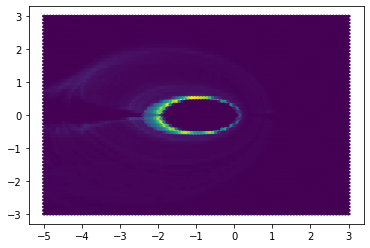

In [ ]:
plt.hexbin(r * np.cos(theta), r * np.sin(theta), extent=(-5, 3, -3, 3))

(1.25, 1.8)

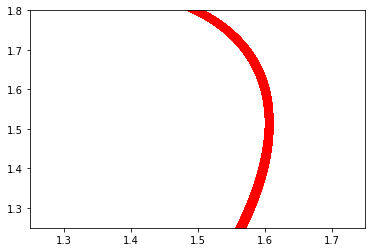

In [ ]:
plt.plot(orbit[:,0],orbit[:,1], "ro")
plt.xlim(1.25,1.75)
plt.ylim(1.25, 1.8)

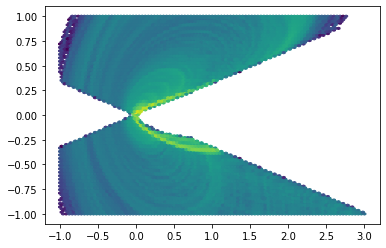

In [ ]:
plt.hexbin(r2 * np.cos(theta[mask]), r2 * np.sin(theta[mask]), extent=(-1, 3, -1, 1), bins="log")

In [ ]:
( arc_len(orbit_theta[:-1][start:end]).min(), radius(orbit_theta[:-1][start:end][~np.isnan(orbit_theta[:-1][start:end])]).max(), orbit_r.min(), orbit_r.max())

(-2.975095992749787,
 2.402812988170756,
 0.13522560830613609,
 2.4061027529248245)

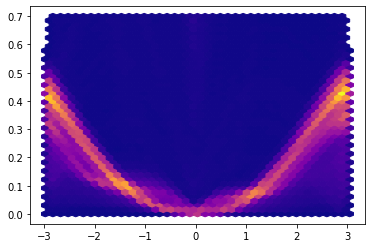

In [ ]:
grid = 40
extent = (arc_len(orbit_theta[:-1][start:end]).min(), arc_len(orbit_theta[:-1][start:end][~np.isnan(orbit_theta[:-1][start:end])]).max(), 0, 0.7)
poly = plt.hexbin(arc_len(theta[mask]), r2, 
                  cmap = 'plasma', gridsize = grid, C = points[mask,4], 
                  reduce_C_function = np.sum, extent = extent)


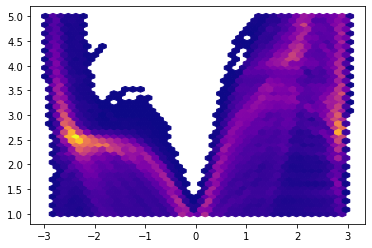

In [ ]:
grid = 40
extent = (arc_len(orbit_theta[:-1][start:end]).min(), arc_len(orbit_theta[:-1][start:end][~np.isnan(orbit_theta[:-1][start:end])]).max(), 1, 5)
poly = plt.hexbin(arc_len(theta[mask]), r[mask]-r_offset(theta[mask]), 
                  cmap = 'plasma', gridsize = grid, C = points[mask,4], 
                 reduce_C_function = np.sum, extent=extent)

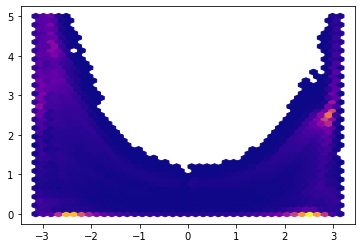

In [ ]:
grid = 40
extent = (-np.pi, np.pi, 0, 5)
poly = plt.hexbin((theta[mask]), r[mask]-r_offset(theta[mask]), 
                  cmap = 'plasma', gridsize = grid, C = points[mask,4], 
                 reduce_C_function = np.sum, extent=extent)

In [ ]:
points_novel = []
points_vel = []
points_distr = []
n = 100
pth = "../output/"

for i in tqdm(range( n)):
    data = np.load(f'{pth}vel/particles{i}.npy')
    beta = np.load(f'{pth}vel/beta{i}.npy')
    size = np.load(f'{pth}vel/mass{i}.npy')
    size = asteroidal(beta)
    data = data.reshape(1000*100*2, 5)
    data = data[:,:3]
    
    
    
    points_vel.append(np.hstack((data, np.tile(size,2000).reshape(200000,1),
                                 np.tile(weight_vel(beta),2000).reshape(200000,1))))
    
points_vel = np.array(points_vel)
points_vel = points_vel.reshape(200000*n,5)

100%|██████████| 100/100 [00:38<00:00,  2.56it/s]


In [ ]:
r = np.sqrt(orbit[:,0]**2 + orbit[:,1]**2 + orbit[:,2]**2)
peri = np.argmin(r)
points = points_vel


perihelion = np.array((orbit[peri,0], orbit[peri,1], orbit[peri, 2]))
point_2 = np.array((orbit[peri-10000,0], orbit[peri-10000,1], orbit[peri-10000, 2]))

p = np.sqrt(np.sum(perihelion**2))
r = np.sqrt(points[:,0]**2 + points[:,1]**2 + points[:,2]**2)
orbit_r = np.sqrt(orbit[:,0]**2 + orbit[:,1]**2 + orbit[:,2]**2)

plane = np.cross(perihelion, point_2)
plane = plane/np.sqrt(np.sum(n**2))
n = np.cross(perihelion, plane)
n = n/np.sqrt(np.sum(n**2))



dot = (points[:,0] * perihelion[0] + points[:,1] * perihelion[1] + points[:,2] * perihelion[2])
ndot= np.sum([points[:,j] * n[j] for j in range(3)], axis=0)
ndot[ndot >= 0] = 1
ndot[ndot <= 0] = -1
theta = np.arccos(dot/(p * r)) * ndot




orbit_dot = (orbit[:,0] * perihelion[0] + orbit[:,1] * perihelion[1])
ndot_o = np.sum([orbit[:,j] * n[j] for j in range(3)], axis=0)
ndot_o[ndot_o >= 0] = 1
ndot_o[ndot_o <= 0] = -1

orbit_theta = np.arccos(orbit_dot/(p * orbit_r)) * ndot_o



<ipython-input-77-8c7a63e0adb1>:22: RuntimeWarning: invalid value encountered in greater_equal
  ndot[ndot >= 0] = 1
<ipython-input-77-8c7a63e0adb1>:23: RuntimeWarning: invalid value encountered in less_equal
  ndot[ndot <= 0] = -1


In [ ]:
mask = (np.abs(theta) > np.min(np.hstack((-orbit_theta[orbit_theta<0], orbit_theta[orbit_theta>0])))) * (theta < np.max(orbit_theta)) * (theta > np.min(orbit_theta))

points = points_vel.copy()
x_offset = scipy.interpolate.interp1d(orbit_theta, orbit[:,0])
y_offset = scipy.interpolate.interp1d(orbit_theta, orbit[:,1])
z_offset = scipy.interpolate.interp1d(orbit_theta, orbit[:,2])
r_offset = scipy.interpolate.interp1d(orbit_theta, orbit_r)
radius = scipy.interpolate.interp1d(orbit_theta, orbit_r*orbit_theta/np.abs(orbit_theta))

points[mask,0] -= x_offset(theta[mask])
points[mask,1] -= y_offset(theta[mask])
points[mask,2] -= z_offset(theta[mask])
r2 = np.sqrt(points[mask,0]**2 + points[mask,1] ** 2 + points[mask,2]**2)

<ipython-input-76-89f364268dee>:1: RuntimeWarning: invalid value encountered in greater
  mask = (np.abs(theta) > np.min(np.hstack((-orbit_theta[orbit_theta<0], orbit_theta[orbit_theta>0])))) * (theta < np.max(orbit_theta)) * (theta > np.min(orbit_theta))
<ipython-input-76-89f364268dee>:1: RuntimeWarning: invalid value encountered in less
  mask = (np.abs(theta) > np.min(np.hstack((-orbit_theta[orbit_theta<0], orbit_theta[orbit_theta>0])))) * (theta < np.max(orbit_theta)) * (theta > np.min(orbit_theta))


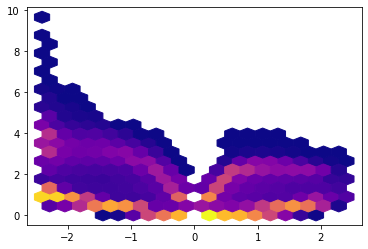

In [ ]:
grid = 20
extent = (orbit_r.min(), orbit_r.max(), 0, 5)
poly = plt.hexbin(radius(theta[mask]), r2, 
                  cmap = 'plasma', gridsize = grid, C = points[mask,4], 
                 reduce_C_function = np.sum)

In [ ]:
grid = 40
extent = (-orbit_r.max(), orbit_r.max(), -1, 5)
poly = plt.hexbin(radius(theta[mask]), r[mask]-r_offset(theta[mask]), 
                  cmap = 'plasma', gridsize = grid, C = points[mask,4], 
                 reduce_C_function = np.sum, extent=extent, bins="log")

IndexError: boolean index did not match indexed array along dimension 0; dimension is 20000 but corresponding boolean dimension is 20000000

In [34]:
points_distr.shape

(13396000, 6)